# ATO Before and after TNFa treatment comparison (Type I Innate T cell population comparison)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
import sys 
import celltypist
from celltypist import models
import time
import scrublet
from scipy.spatial import distance
from scipy.sparse import csr_matrix

In [2]:
# THIS IS SAMPLE 6180STDY13657795 WITH CITE-SEQ 6180STDY13657796 -Kolf

In [3]:
# Run before souporcell 
def initial_raw_data_preprocessing(sanger_sample_id, write_barcode_file):

    print('Sanger sample id: ' , sanger_sample_id)
   # path = RAW_DATA_PATH + 'ATO_sample_raw_count_matrices/' +'raw_feature_bc_matrix_' + sanger_sample_id +'/'
    
    path = '../../../irods_test/ATO_sample_raw_count_matrices/raw_feature_bc_matrix_6180STDY13657796/'
    print(path)
    
    adata = sc.read(path+'matrix.mtx.gz',cache=True).transpose()
    adata.var_names = np.genfromtxt(path + 'features.tsv.gz',dtype=str)[:,1]
    adata.obs_names = np.genfromtxt(path + 'barcodes.tsv.gz',dtype=str)
    adata.obs['sanger_sample_id'] = np.repeat(sanger_sample_id,adata.shape[0])
    # adata = sc.read_10x_h5(sample_raw_count_matrix_file) # this misses antibody hashtags specific features
    adata.var_names_make_unique()
    print('Raw size: ',adata.shape) # (737280, 64596)
    mito_genes = adata.var_names.str.startswith('GRCh38_MT-') 
    human_genes = adata.var_names.str.startswith('GRCh38') 
    mouse_genes = adata.var_names.str.startswith('mm10_') 
    
   # print(np.unique(mito_genes, return_counts=True)) # 13 genes
   # print(np.unique(human_genes, return_counts=True)) # 33538 genes
   # print(np.unique(mouse_genes, return_counts=True )) # 31053 genes
    
    GEX = human_genes + mouse_genes
    #Antibody_capture = ~GEX
    #print('Antibody capture genes: ',np.unique(Antibody_capture,return_counts=True))
    #print(np.unique(np.sum(adata[:,Antibody_capture].X, axis=1).A1,return_counts=True))
    #return

    total_UMI_count_across_human_genes = np.sum(adata.X[:, human_genes],axis=1).A1 
    total_UMI_count_across_mito_genes = np.sum(adata.X[:, mito_genes],axis=1).A1
    total_UMI_count_across_genes = np.sum(adata.X[:, GEX],axis=1).A1  # the total UMI count for each cell across all genes
    n_genes_expressed = np.sum(adata[:,GEX].X>0,axis=1).A1  # the # of genes that are expressed (UMI!=0)
    adata.obs['percent_total_human_UMI'] = np.nan_to_num(np.divide(total_UMI_count_across_human_genes,total_UMI_count_across_genes)) 
    adata.obs['percent_total_mito_UMI']= np.nan_to_num(np.divide(total_UMI_count_across_mito_genes,total_UMI_count_across_genes))
    adata.obs['human_cells'] = adata.obs['percent_total_human_UMI']>0.9
    adata.obs['total_UMI_count_across_genes'] = total_UMI_count_across_genes
    adata.obs['n_genes_expressed'] = n_genes_expressed 

    print('Filtering cells')
    adata = adata[adata.obs['percent_total_human_UMI']>0.9]  #If >90% reads are from human genes then they are called human_cells
    adata = adata[adata.obs['total_UMI_count_across_genes'] > 2000]
    adata = adata[adata.obs['n_genes_expressed'] > 500] # sc.pp.filter_cells(adata_check, min_genes=500)
    adata = adata[adata.obs['n_genes_expressed'] < 7000] # sc.pp.filter_cells(adata_check, max_genes=7000)
    adata = adata[adata.obs['percent_total_mito_UMI']<0.1] # sc.pp.filter_cells(adata_check, min_counts=2000) 
    
    # Write barcode list to csv file --- for running souporcell by Krzysztof
    if(write_barcode_file and sanger_sample_id in np.asarray(meta[meta.human_cell_batch == 'souporcell_Fiaj_Kolf'].sequence_name)):
        print('writing barcode file')
        pd.DataFrame(adata.obs_names).to_csv('Barcodes_'+sanger_sample_id+'.csv',index=False,header=False)
    print('Filtered size: ',adata.shape)
    
    return adata


adata = initial_raw_data_preprocessing('6180STDY13657796', write_barcode_file=False)

Sanger sample id:  6180STDY13657796
../../../irods_test/ATO_sample_raw_count_matrices/raw_feature_bc_matrix_6180STDY13657796/
Raw size:  (737280, 64595)
Filtering cells
Filtered size:  (174, 64595)


In [4]:
samples = [adata]

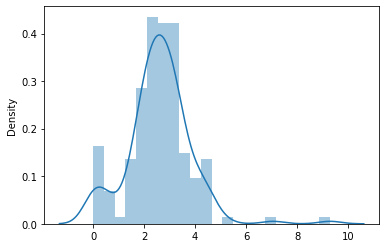

In [5]:
# deciding the mito % threshold for cell filtering based on IQR outliers
sample_mito_thresholds = []
all_samples_mito_percentages = [] 
for i in range(len(samples)):
    all_samples_mito_percentages = all_samples_mito_percentages + list(samples[i].obs.percent_total_mito_UMI)
    sb.distplot(np.asarray(samples[i].obs.percent_total_mito_UMI)*100)
    Q1,Q3 = np.percentile(samples[i].obs.percent_total_mito_UMI,[25,75])
    IQR = Q3-Q1
    U = Q3 + (1.5*IQR)
    sample_mito_thresholds.append(U)
#  adata = adata[adata.obs['percent_total_mito_UMI']<0.2] # sc.pp.filter_cells(adata_check, min_counts=2000)

4.990012897178531


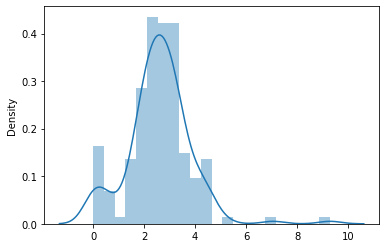

In [7]:

#Across all samples, mito read % distribution
sb.distplot(np.asarray(all_samples_mito_percentages)*100) 
Q1,Q3 = np.percentile(all_samples_mito_percentages,[25,75])
IQR = Q3-Q1
U = Q3 + (1.5*IQR)
print(U*100)

Scrublet run for -  6180STDY13657796
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 7.5%
Estimated detectable doublet fraction = 21.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 35.6%
Elapsed time: 0.3 seconds


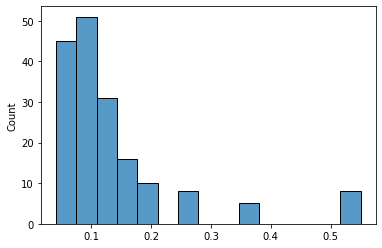

In [8]:
sanger_sample_IDs = ['6180STDY13657796']
# Per sample doublet prediction 
for i in range(len(samples)):
    print('Scrublet run for - ', sanger_sample_IDs[i])
    if(samples[i].shape[0]<10):
        print('NOT RUN DUE TO INSUFFICIENT CELLS')
        samples[i].obs['scrublet_doublet_scores_individual_sample_based'] = np.repeat(0.0,samples[i].shape[0])
        samples[i].obs['scrublet_predicted_doublets_individual_sample_based'] = np.repeat(0.0,samples[i].shape[0])
        continue
    scrub = scrublet.Scrublet(samples[i].X)
    scrublet_doublet_scores, scrublet_predicted_doublets = scrub.scrub_doublets()
    sb.histplot(scrublet_doublet_scores)
    samples[i].obs['scrublet_doublet_scores_individual_sample_based'] = scrublet_doublet_scores
    samples[i].obs['scrublet_predicted_doublets_individual_sample_based'] = scrublet_predicted_doublets

In [9]:
# This is T23_Kolf_TNF_wk7 batch

In [10]:
i=0;
while(i<len(samples)):
    temp = samples[i].copy() 
    temp.obs_names = np.asarray(samples[i].obs_names + '-' + samples[i].obs.sanger_sample_id) 
    #adata = adata.concatenate(samples[i],join='outer')
    if i > 0:
        adata = anndata.concat([adata, temp], join='outer', merge='first',index_unique=None)
    else:
        adata = temp
    i=i+1
adata = adata[:,~adata.var_names.str.startswith('mm10')] # remove mouse genes
adata_bck = adata.copy()

In [11]:
adata

View of AnnData object with n_obs × n_vars = 174 × 33542
    obs: 'sanger_sample_id', 'percent_total_human_UMI', 'percent_total_mito_UMI', 'human_cells', 'total_UMI_count_across_genes', 'n_genes_expressed', 'scrublet_doublet_scores_individual_sample_based', 'scrublet_predicted_doublets_individual_sample_based'

In [13]:
Antibody_capture = adata.var_names[~adata.var_names.str.startswith(('GRCh38'))]
temp = []
for barcode in Antibody_capture:
    k = adata[:,barcode].X.todense()
    print(barcode, np.unique(adata[:,barcode][k>0].obs.sanger_sample_id)) 
    temp = temp + list(np.unique(adata[:,barcode][k>0].obs.sanger_sample_id)) 

Kolf_WT ['6180STDY13657796']
Kolf_TNF1ng ['6180STDY13657796']
Kolf_TNF5ng ['6180STDY13657796']
Kolf_TNF25ng ['6180STDY13657796']


In [14]:
# Antibody calling and saving in obs, then removing from var, retaining only the human genes.
Antibody_capture = adata.var_names[~adata.var_names.str.startswith(('GRCh38'))]
Antibody_capture
adata.obs['Antibody_max_perc'] = np.max(adata[:,Antibody_capture].X, axis=1) / np.sum(adata[:,Antibody_capture].X, axis=1)

In [18]:
#Antibody_capture[np.argmax(np.array(adata[:,Antibody_capture].X.todense()),axis=1)]
temp = []
for i in range(adata.shape[0]):
    if(np.all(adata[i,Antibody_capture].X.todense()==0)):
        temp.append(str(np.NaN))
    else:
        temp.append(Antibody_capture[np.argmax(np.array(adata[i,Antibody_capture].X.todense()),axis=1)][0]) 
adata.obs['Antibody_calling'] = np.asarray(temp)
np.unique(adata.obs['Antibody_calling'], return_counts=True)

(array(['Kolf_TNF1ng', 'Kolf_TNF25ng', 'Kolf_WT'], dtype=object),
 array([152,   8,  14]))

In [19]:
np.min(adata.obs['Antibody_max_perc']) 

0.7417582

In [20]:
#adata.obs['Antibody_calling'] = Antibody_capture[np.argmax(np.array(adata[:,Antibody_capture].X.todense()),axis=1)] # this returns default 0 index when 0 capture across all antibody hashtags
#plt.hist(adata.obs['Antibody_max_perc'])
adata.obs.loc[adata.obs['Antibody_max_perc'] < 0.5,'Antibody_calling'] = np.nan
# The separate cell lines identified by different antibody tags
adata.var_names[~adata.var_names.str.startswith(('GRCh38'))]
adata = adata[:,adata.var_names.str.startswith(('GRCh38'))]
#No need to do this now ---- I've already handled this problem from above loop even if it takes a bit of time ---- nohashtag_samples = ['6180STDY9448811', '6180STDY10267739', '6180STDY10267835', '6180STDY10267836', '6180STDY11348263', '6180STDY11348266', '6180STDY11348267','6180STDY11605355']
# correcting the antibody calling for non hashtag samples
#adata.obs.Antibody_calling[adata.obs.sanger_sample_id.isin(nohashtag_samples)] = np.NaN

In [21]:
adata
pd.Series(adata.obs.Antibody_calling).unique()

array(['Kolf_TNF25ng', 'Kolf_TNF1ng', 'Kolf_WT'], dtype=object)

In [22]:
np.unique(adata.obs['Antibody_calling'], return_counts=True)

(array(['Kolf_TNF1ng', 'Kolf_TNF25ng', 'Kolf_WT'], dtype=object),
 array([152,   8,  14]))

In [24]:
# making variable names (gene names) compatible with common gene names e.g. <hg38_1hho> = 1hho
modified_varnames = []
for gene in adata.var_names:
    modified_varnames.append(gene[7:len(gene)])
adata.var_names = modified_varnames
adata

AnnData object with n_obs × n_vars = 174 × 33538
    obs: 'sanger_sample_id', 'percent_total_human_UMI', 'percent_total_mito_UMI', 'human_cells', 'total_UMI_count_across_genes', 'n_genes_expressed', 'scrublet_doublet_scores_individual_sample_based', 'scrublet_predicted_doublets_individual_sample_based', 'Antibody_max_perc', 'Antibody_calling'

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 4.0%
Estimated detectable doublet fraction = 18.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 22.2%
Elapsed time: 0.2 seconds


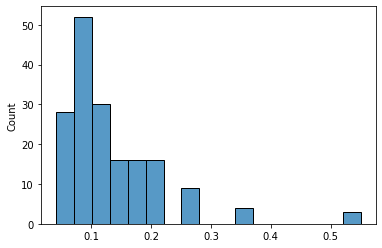

In [25]:
scrub = scrublet.Scrublet(adata.X)
scrublet_doublet_scores, scrublet_predicted_doublets = scrub.scrub_doublets()
sb.histplot(scrublet_doublet_scores)
adata.obs['scrublet_doublet_scores'] = scrublet_doublet_scores
adata.obs['scrublet_predicted_doublets'] = scrublet_predicted_doublets

In [26]:
np.unique(adata.obs['Antibody_calling'], return_counts=True)

(array(['Kolf_TNF1ng', 'Kolf_TNF25ng', 'Kolf_WT'], dtype=object),
 array([152,   8,  14]))

In [27]:
adata

AnnData object with n_obs × n_vars = 174 × 33538
    obs: 'sanger_sample_id', 'percent_total_human_UMI', 'percent_total_mito_UMI', 'human_cells', 'total_UMI_count_across_genes', 'n_genes_expressed', 'scrublet_doublet_scores_individual_sample_based', 'scrublet_predicted_doublets_individual_sample_based', 'Antibody_max_perc', 'Antibody_calling', 'scrublet_doublet_scores', 'scrublet_predicted_doublets'

In [29]:
adata.write_h5ad('ATO_TNF.h5ad', compression='gzip')

... storing 'sanger_sample_id' as categorical
... storing 'Antibody_calling' as categorical


# Preprocessing new data

In [2]:
adata = anndata.read_h5ad('ATO_TNF.h5ad')
# filtering doublets
CUTOFF = 0.15
adata = adata[adata.obs['scrublet_doublet_scores_individual_sample_based']<CUTOFF] 

In [4]:
np.unique(adata.obs['Antibody_calling'], return_counts=True)

(array(['Kolf_TNF1ng', 'Kolf_TNF25ng', 'Kolf_WT'], dtype=object),
 array([120,   6,   1]))

In [6]:
adata.raw = adata.copy() # storing raw counts before filtering genes
adata.raw.shape

(127, 33538)

In [7]:
# remove cell cycle genes
cc_genes = pd.read_csv('regev_lab_cell_cycle_genes.txt', header=None ) # https://notebook.community/theislab/scanpy_usage/180209_cell_cycle/cell_cycle -- 97 CC GENES
cc_genes = np.asarray(cc_genes[0]) 
len(cc_genes)

97

In [8]:
#cc_genes = ['C1orf112', 'KDM1A', 'ARHGAP33', 'CDC27', 'AC004381.6', 'DBF4', 'PRSS21', 'E2F2', 'BAZ1B', 'NCAPD2', 'ANLN', 'BRCA1', 'UBR7', 'DDX11', 'TACC3', 'POLA2', 'DEPDC1', 'NCAPH2', 'HMGB3', 'CENPQ', 'DEPDC1B', 'SPDL1', 'TDP1', 'DSG2', 'NOP16', 'RFC2', 'RAD51', 'POLQ', 'THOC3', 'MRTO4', 'C4orf27', 'POLD1', 'TM7SF3', 'MCM10', 'MTHFD2', 'YBX1', 'ASPM', 'PRR11', 'NUCKS1', 'EXOC5', 'TCOF1', 'RAD18', 'TRIP13', 'DAZAP1', 'HLTF', 'PDCD2', 'SMC1A', 'HMMR', 'MCM2', 'NUP37', 'GTSE1', 'WDR62', 'MCM6', 'MLH1', 'UNG', 'SPAG5', 'UBE2T', 'EXOSC5', 'FAM76B', 'POLD3', 'KIF22', 'PUM3', 'RBL1', 'NDC80', 'HSPB11', 'OXCT1', 'SEH1L', 'ORC1', 'RAD54L', 'NOP14', 'GMCL1', 'AURKA', 'TPX2', 'BIRC5', 'KIF4A', 'FH', 'ORC6', 'G2E3', 'WDR76', 'PHGDH', 'CLSPN', 'NUP50', 'CDC45', 'CDC6', 'CBX5', 'MSH2', 'FKBP5', 'ACOT7', 'CDC7', 'RANBP1', 'CENPM', 'HMGXB4', 'MCM5', 'RANGAP1', 'POLE2', 'CDKN3', 'ERH', 'MTHFD1', 'VRK1', 'EMC9', 'GINS1', 'MYBL2', 'CDC25B', 'PLCB4', 'FAM83D', 'CEP76', 'RBBP8', 'POLA1', 'NUP93', 'CTCF', 'CCP110', 'CEP152', 'OIP5', 'MYEF2', 'MCM4', 'KCTD9', 'RNASEH2A', 'SGTA', 'ASF1B', 'LIG1', 'H2AFV', 'GARS', 'NUDT1', 'RPA3', 'EZH2', 'RHEB', 'SMC3', 'UBE2S', 'RAD51C', 'GALK1', 'C1QBP', 'BLMH', 'TMEM97', 'GAR1', 'NEIL3', 'WHSC1', 'NCAPG', 'CCDC34', 'CCDC86', 'MAGOHB', 'FOXM1', 'GPN3', 'RAD51AP1', 'RFC5', 'NUP107', 'TIMELESS', 'GAPDH', 'CDCA3', 'ENO2', 'FBXO5', 'MCM3', 'BAG2', 'GMNN', 'TTK', 'HMGCS1', 'BRD8', 'KIF20A', 'LMNB1', 'NUP155', 'H2AFY', 'SMC4', 'ECT2', 'CENPA', 'FHL2', 'MSH6', 'DHCR24', 'LRRC42', 'WDR77', 'SRM', 'MAD2L2', 'UCHL5', 'TTF2', 'SLC2A1', 'EBNA1BP2', 'CDC20', 'STMN1', 'NEK2', 'CENPF', 'KIF14', 'CASP8AP2', 'CTNNAL1', 'WDR34', 'PHF19', 'ACYP1', 'EPCAM', 'HELLS', 'CENPL', 'ACAT2', 'MASTL', 'EXOSC8', 'TMPO', 'NFYB', 'NCAPH', 'MND1', 'KIF18A', 'GPSM2', 'GTF3A', 'MRPS2', 'CCDC18', 'CISD1', 'ZWINT', 'CIT', 'DDX39A', 'CENPK', 'CDK2', 'TUBA1B', 'STIL', 'HJURP', 'EXOSC9', 'CKS2', 'ACSL3', 'CSE1L', 'HIST1H1D', 'HIST1H1A', 'DEK', 'GOT2', 'MGME1', 'MCM8', 'HNRNPR', 'BCL2L12', 'TRAP1', 'DLGAP5', 'YEATS4', 'PKMYT1', 'SRD5A3', 'PAICS', 'HAT1', 'KNSTRN', 'DUT', 'E2F8', 'FAM64A', 'MIS18BP1', 'SGOL1', 'RPS4Y1', 'LDLR', 'TOMM40', 'ATP8B3', 'LSM4', 'DNMT1', 'GINS2', 'TUBG1', 'PSMC3IP', 'THOC6', 'TOP2A', 'ENOSF1', 'RAN', 'RPA1', 'PCNA', 'NASP', 'RFC3', 'SLF1', 'LRRCC1', 'CCNB1', 'PSRC1', 'TMEM106C', 'LDHA', 'DDB2', 'CDCA8', 'TPGS2', 'SLC43A3', 'C9orf40', 'TROAP', 'ESPL1', 'NTPCR', 'CKAP2', 'BORA', 'NUDT15', 'BRIP1', 'ACTL6A', 'TXN', 'ODF2', 'SMC2', 'CDK5RAP2', 'ANP32B', 'DSCC1', 'ARHGEF39', 'PPIL1', 'TCF19', 'NRM', 'GGH', 'BUD13', 'CTDSPL2', 'NUSAP1', 'KIF23', 'CASC5', 'CENPO', 'KIF11', 'CEP55', 'KIF20B', 'DNA2', 'BARD1', 'MNS1', 'ZGRF1', 'CENPE', 'HADH', 'SLC39A8', 'NEDD1', 'BRCA2', 'DIAPH3', 'PIF1', 'FANCI', 'TICRR', 'SAMD1', 'SAE1', 'PLK4', 'ITGB3BP', 'KIF2C', 'UCK2', 'NUF2', 'ANP32E', 'DTL', 'ILF2', 'C1orf35', 'HNRNPLL', 'CHAC2', 'POLR2D', 'CDCA7', 'FANCD2', 'CCNA2', 'SKP2', 'PRIM2', 'MMS22L', 'PM20D2', 'MTFR2', 'CDCA5', 'NCAPG2', 'PRPS1', 'GINS4', 'HAUS6', 'CEP78', 'GTF3C5', 'MKI67', 'IMMP1L', 'SSRP1', 'INCENP', 'CCDC15', 'CHEK1', 'DSN1', 'HIRIP3', 'HMGA2', 'TEX30', 'NCAPD3', 'CENPU', 'CENPJ', 'SPC25', 'SUV39H2', 'CENPH', 'CARHSP1', 'CLGN', 'CCSAP', 'BUB3', 'SLFN13', 'SKA1', 'SLC16A1', 'TMEM237', 'ADK', 'FAM122B', 'AIFM1', 'ATAD2', 'SASS6', 'BUB1B', 'CCNB2', 'PSMG3', 'FAIM', 'CDC25C', 'MIS18A', 'ATP5G1', 'IGF2BP1', 'CHAF1B', 'NAE1', 'CCDC58', 'C21orf58', 'ZNF714', 'GPATCH4', 'YDJC', 'RACGAP1', 'SPC24', 'POLR3K', 'CCNF', 'ASRGL1', 'USP1', 'KIAA1524', 'SGOL2', 'TOPBP1', 'KIF15', 'WDR43', 'RFC4', 'RPL39L', 'RNF168', 'H2AFZ', 'CDC25A', 'POC1A', 'HMGB2', 'MAD2L1', 'PTTG1', 'RAD21', 'PSIP1', 'GKAP1', 'MELK', 'SLC7A3', 'SKA3', 'LRR1', 'HPRT1', 'E2F7', 'JAM3', 'BRD7', 'CENPN', 'LEO1', 'WEE1', 'MCM7', 'CENPV', 'SAAL1', 'FAM111A', 'KIAA0101', 'PLK1', 'XRCC6BP1', 'SNRPD1', 'RRM1', 'CDT1', 'CHAF1A', 'C19orf48', 'NUDT8', 'PRDX2', 'TK1', 'SAC3D1', 'PBK', 'HIST1H1E', 'DTYMK', 'RFWD3', 'FEN1', 'ING2', 'CDKN2AIP', 'SNRNP48', 'USP39', 'CKAP2L', 'BUB1', 'ELP5', 'CDK1', 'CDCA4', 'SHCBP1', 'PGAM1', 'ESCO2', 'RHNO1', 'CTPS1', 'RRM2', 'THOP1', 'C5orf34', 'POP7', 'ZNF738', 'CKS1B', 'GMPPB', 'CNP', 'CBX2', 'C16orf91', 'EXO1', 'ZWILCH', 'ANKRD36C', 'UBE2C', 'CKAP5', 'CCNE2', 'CCDC14', 'RMI2', 'TOMM5', 'RUVBL1', 'ATAD5', 'LMNB2', 'TYMS', 'PXMP2', 'SHMT1', 'POLE', 'PAWR', 'PIDD1', 'GSG2', 'GEN1', 'RMI1', 'AURKB', 'RCC1', 'PPA1', 'HIST3H2A', 'MRPS23', 'RTKN2', 'IDH2', 'KPNA2', 'CEP97', 'GLRX5', 'SKA2', 'CEP57L1', 'PSMG1', 'SFXN4', 'ALYREF', 'TRAIP', 'LIN9', 'KMT5A', 'PGP', 'CMSS1', 'HIST2H2AC', 'HIST1H1B', 'KNTC1', 'CDCA2', 'H1FX', 'SIVA1', 'PARPBP', 'KIF18B', 'ERCC6L', 'PTMA', 'HSPA14', 'FANCA', 'ARHGAP11B', 'TUBB4B', 'CENPP', 'H2AFX', 'FAM72B', 'FAM221A', 'FAM111B', 'HN1', 'HMGB1', 'TUBB', 'IARS', 'ERI2', 'HIST1H4C', 'BLM', 'PRIM1', 'HMGN5', 'SVIP', 'TFDP1', 'TXNRD1', 'WDHD1', 'EIF1AY', 'ARHGAP11A', 'HMGN2', 'DCAF12', 'PRC1', 'CCDC167', 'CENPW', 'GPANK1', 'MZT1', 'C4orf46', 'KLHL23', 'MXD3', 'DNAJC9', 'IFRD2', 'CKLF', 'FANCG', 'DHFR', 'DLEU2', 'AP000251.3', 'KIFC1', 'CRNDE', 'C8orf88', 'PRKDC', 'BOP1', 'RP11-196G18.23', 'CTC-260E6.6', 'NCBP2-AS2', 'HIST1H3G', 'HIST1H2AH', 'UHRF1', 'RDM1', 'HIST1H2AM']
relevent_cc_genes = [] 
for cc_gene in cc_genes:
    if(cc_gene in adata.var_names):
        relevent_cc_genes.append(cc_gene)
adata = adata[:,np.setdiff1d(adata.var_names,relevent_cc_genes)] 

In [9]:
sc.pp.filter_genes(adata, min_cells=3) 
#adata.var['mt'] = adata.var_names.str.startswith('MT-') 
#sc.pp.calculate_qc_metrics(adata, qc_vars= ['mt'],percent_top=None, log1p=False, inplace=True)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_per_cell(adata, 10000) 
sc.pp.log1p(adata)
#adata.raw = adata.copy()
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata,max_value=10)
sc.tl.pca(adata,svd_solver='arpack',use_highly_variable=True)

In [11]:
adata.raw.X.data

array([ 1.,  2.,  1., ..., 32.,  6., 33.], dtype=float32)

In [12]:
temp_adata = adata.raw.to_adata()
temp_adata.layers['counts'] = temp_adata.X
adata_bck = adata.copy()
adata = temp_adata.copy()
sc.pp.normalize_per_cell(adata, 10000) 
sc.pp.log1p(adata)

In [14]:
adata.X.data

array([0.8220613, 1.2670517, 0.8220613, ..., 2.981801 , 1.5064346,
       3.011035 ], dtype=float32)

In [15]:
import celltypist
run_celltypist = True
if(run_celltypist):
    predictions = celltypist.annotate(adata, model = 'Pan_Fetal_Human.pkl',majority_voting=True)
    predictions_high_level = celltypist.annotate(adata, model = "Immune_Thymus_High.pkl", majority_voting=True)
    predictions_low_level = celltypist.annotate(adata, model = "Immune_Thymus_Low.pkl", majority_voting=True)
    adata.obs['celltypist_panfetal_predictions'] = predictions.predicted_labels['majority_voting']
    adata.obs['celltypist_high_level_predictions'] = predictions_high_level.predicted_labels['majority_voting']
    adata.obs['celltypist_low_level_predictions'] = predictions_low_level.predicted_labels['majority_voting']
    
    high_level_predictions = []
    for i in range(0,adata.shape[0]):
        annotation = adata.obs['celltypist_panfetal_predictions'][i]
        if(annotation.startswith('DP')):
            high_level_predictions.append('DP')
        elif(annotation.startswith('DN')):
            high_level_predictions.append('DN')      
        elif(annotation.startswith('MONOCYTE')):
            high_level_predictions.append('MONOCYTE')   
        elif(annotation.endswith('INNATE_T')):
            high_level_predictions.append('INNATE_T') 
        elif(annotation.endswith('_MK')):
            high_level_predictions.append('MK') 
        elif(annotation.endswith('_MPP')):
            high_level_predictions.append('MPP') 
        elif(annotation.endswith('_MEMP')):
            high_level_predictions.append('MEMP') 
        elif(annotation.endswith('_NK')):
            high_level_predictions.append('NK') 
        else:
            high_level_predictions.append(annotation)
    adata.obs['celltypist_panfetal_predictions_high_level'] = high_level_predictions

🔬 Input data has 127 cells and 33538 genes
🔗 Matching reference genes in the model
🧬 6971 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 127 cells and 33538 genes
🔗 Matching reference genes in the model
🧬 3800 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 127 cells and 33538 genes
🔗 Matching reference genes in the model
🧬 4911 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object,

In [16]:
adata_bck.obs['celltypist_panfetal_predictions'] = adata.obs.celltypist_panfetal_predictions
adata_bck.obs['celltypist_high_level_predictions'] = adata.obs.celltypist_high_level_predictions
adata_bck.obs['celltypist_low_level_predictions'] = adata.obs.celltypist_low_level_predictions
adata_bck.obs['celltypist_panfetal_predictions_high_level'] = adata.obs.celltypist_panfetal_predictions_high_level
adata = adata_bck.copy() 

In [17]:
adata

AnnData object with n_obs × n_vars = 127 × 2177
    obs: 'sanger_sample_id', 'percent_total_human_UMI', 'percent_total_mito_UMI', 'human_cells', 'total_UMI_count_across_genes', 'n_genes_expressed', 'scrublet_doublet_scores_individual_sample_based', 'scrublet_predicted_doublets_individual_sample_based', 'Antibody_max_perc', 'Antibody_calling', 'scrublet_doublet_scores', 'scrublet_predicted_doublets', 'n_counts', 'celltypist_panfetal_predictions', 'celltypist_high_level_predictions', 'celltypist_low_level_predictions', 'celltypist_panfetal_predictions_high_level'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [18]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata) 

... storing 'celltypist_panfetal_predictions_high_level' as categorical


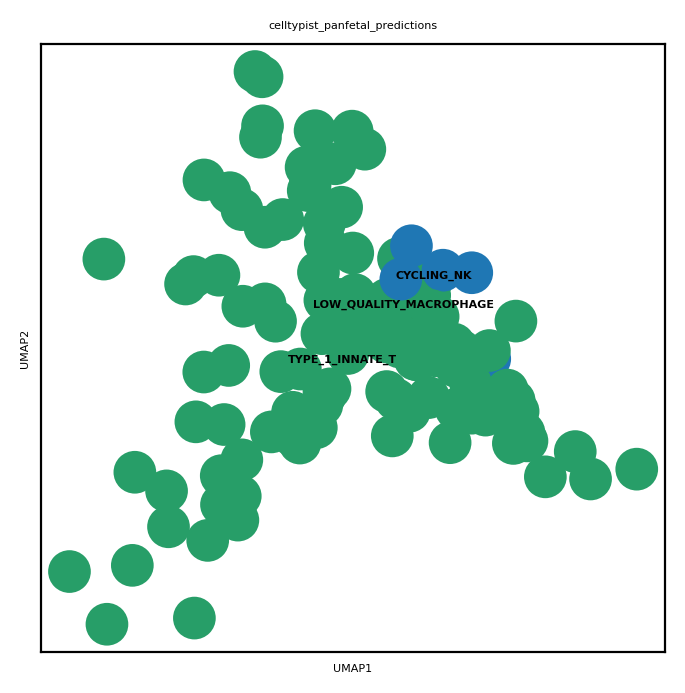

In [19]:
sc.set_figure_params(fontsize=4, dpi=200)
sc.pl.umap(adata,color=['celltypist_panfetal_predictions'],legend_loc='on data')

In [20]:
np.unique(adata.obs['Antibody_calling'], return_counts=True)

(array(['Kolf_TNF1ng', 'Kolf_TNF25ng', 'Kolf_WT'], dtype=object),
 array([120,   6,   1]))

In [49]:
adata_all = adata.raw.to_adata()
T_cells = adata_all[adata_all.obs.celltypist_panfetal_predictions=='TYPE_1_INNATE_T'] 
T_cells.write_h5ad('adata_Tcells_TNFa_Data_w_counts.h5ad')
#T_cells = adata[adata.obs.celltypist_panfetal_predictions=='TYPE_1_INNATE_T'] 

In [51]:
#T_cells = T_cells.raw.to_adata()
sc.pp.normalize_per_cell(T_cells, 10000) 
sc.pp.log1p(T_cells)

In [49]:
np.unique(T_cells.obs['Antibody_calling'], return_counts=True)

(array(['Kolf_TNF1ng', 'Kolf_TNF25ng'], dtype=object), array([113,   6]))

In [52]:
T_cells.write_h5ad('adata_Tcells_TNFa_Data.h5ad')

# Comparing with pan fetal reference and previous ATO final stage T cells 

In [1]:
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
import sys 
from scipy.sparse import csr_matrix
anndata.__version__

'0.8.0'

In [ ]:
adata_ref = anndata.read_h5ad('PanfetalATO_SPT_gplvm_ref_24012023.h5ad')
adata_query = anndata.read_h5ad('PanfetalATO_SPT_gplvm_ATO_24012023.h5ad')
adata_Tcells_TNF = anndata.read_h5ad('adata_Tcells_TNFa_Data.h5ad')

In [ ]:
adata_Tcells_TNF

In [4]:
np.unique(adata_Tcells_TNF.obs['Antibody_calling'], return_counts=True)

(array(['Kolf_TNF1ng', 'Kolf_TNF25ng'], dtype=object), array([113,   6]))

In [5]:
adata_ref_t1 = adata_ref[adata_ref.obs.ANNOTATION_COMB =='TYPE_1_INNATE_T'] 

In [6]:
adata_query_spt = adata_query[adata_query.obs.ANNOTATION_COMB == 'SP_T'] 

In [7]:
print(adata_ref_t1.shape)
print(adata_query_spt.shape)
print(adata_Tcells_TNF.shape)

(1413, 20240)
(6558, 20240)
(119, 33538)


In [8]:
import MyFunctions
def compute_mmldist(gex1,gex2):
    
        if(not gex1.any()):
            μ_S = 0.0; σ_S=0.1
        else:
            μ_S = np.mean(gex1); σ_S = np.std(gex1); 
        if(not gex2.any()):
            μ_T = 0.0; σ_T=0.1
        else:
            μ_T = np.mean(gex2); σ_T = np.std(gex2); 
        
        ref_data = gex1 
        query_data = gex2

        I_ref_model, I_refdata_g_ref_model = MyFunctions.run_dist_compute_v3(ref_data, μ_S, σ_S) 
        I_query_model, I_querydata_g_query_model = MyFunctions.run_dist_compute_v3(query_data, μ_T, σ_T) 
        I_ref_model, I_querydata_g_ref_model = MyFunctions.run_dist_compute_v3(query_data, μ_S, σ_S) 
        I_query_model, I_refdata_g_query_model = MyFunctions.run_dist_compute_v3(ref_data, μ_T, σ_T) 
        
        match_encoding_len1 = I_ref_model + I_querydata_g_ref_model + I_refdata_g_ref_model
        match_encoding_len1 = match_encoding_len1/(len(query_data)+len(ref_data))
        match_encoding_len2 = I_query_model + I_refdata_g_query_model + I_querydata_g_query_model
        match_encoding_len2 = match_encoding_len2/(len(query_data)+len(ref_data))
        match_encoding_len = (match_encoding_len1 + match_encoding_len2 )/2.0 
        
        null = (I_ref_model + I_refdata_g_ref_model + I_query_model + I_querydata_g_query_model)/(len(query_data)+len(ref_data))
        match_compression =   match_encoding_len - null 

        return round(float(match_compression.numpy()),4) 
    

def check_dists(TF, PLOT=False):
    
    ato_tnf = np.asarray(adata_Tcells_TNF[:,TF].X.todense()).flatten()
    ref = np.asarray(adata_ref_t1[:,TF].X.todense()).flatten()
    ato = np.asarray(adata_query_spt[:,TF].X.todense()).flatten()
    
   # if(not ato_tnf.any() or not ato.any() or not ref.any()):
   #     print('ALERT 0 expression in at least one case', TF) # only MSC gene is here so let's remove it

    ref_ato_mmldist = compute_mmldist(ref, ato)
    ref_ato_tnf_mmldist = compute_mmldist(ref, ato_tnf)

    # plotting positive expression only
    if(PLOT):
        sb.kdeplot(ref[ref>0], fill=True)
        sb.kdeplot(ato[ato>0], fill=True)
        sb.kdeplot(ato_tnf[ato_tnf>0], fill=True)
        plt.legend(['Ref','ATO','ATO-TNFa'])
        print('ref mean: ', np.mean(ref))
        print('ato mean: ', np.mean(ato))
        print('ato_tnf mean: ', np.mean(ato_tnf))
    
    return [np.mean(ref), np.mean(ato), np.mean(ato_tnf)], ref_ato_mmldist, ref_ato_tnf_mmldist 


In [9]:
g = np.intersect1d(adata_ref_t1.var_names, adata_query_spt.var_names)

In [10]:
# Load the Human TF list
def get_human_TF_list(): 
    # get a human TF list 
    TF_list = pd.read_csv('huamn_TF_list.csv',skiprows=1)
    np.unique(TF_list['Unnamed: 3'], return_counts=True) 
    TF_list = TF_list[TF_list['Unnamed: 3']=='Yes']
    TF_list['Name']
    return TF_list
human_TFs = get_human_TF_list()
human_TFs = np.intersect1d(human_TFs.Name, np.intersect1d(g, adata_Tcells_TNF.var_names))

In [11]:
len(human_TFs)

1371

### Running MML distance across all 1371 TFs 

In [142]:
len(human_TFs )
from tqdm import tqdm
mean_expression_df = []
ref_ato_mmldists = []
ref_ato_tnf_mmldists = []
genes = []
#mean_expression_df_zscore = []
for g in tqdm(human_TFs):
    genes.append(g)
    x, ref_ato_mmldist, ref_ato_tnf_mmldist  = check_dists(g)
    mean_expression_df.append(x)
    ref_ato_mmldists.append(ref_ato_mmldist)
    ref_ato_tnf_mmldists.append(ref_ato_tnf_mmldist)
    #mean_expression_df_zscore.append(x_zscore)

100%|██████████| 1371/1371 [02:50<00:00,  8.06it/s]


In [143]:
import statistics
ref_ato_mmldists = np.asarray(ref_ato_mmldists)
ref_ato_tnf_mmldists = np.asarray(ref_ato_tnf_mmldists)
print(np.mean(ref_ato_mmldists))
print(np.mean(ref_ato_tnf_mmldists))

0.3502121808898614
0.15933946024799417


In [144]:
import scipy.stats as stats
stats.wilcoxon(ref_ato_mmldists, ref_ato_tnf_mmldists)

WilcoxonResult(statistic=362702.0, pvalue=2.208703426697978e-13)

In [145]:
data = list(ref_ato_mmldists) + list(ref_ato_tnf_mmldists) 
labels = list(np.repeat('ref_ato',len(ref_ato_mmldists))) + list(np.repeat('ref_ato_tnfa',len(ref_ato_tnf_mmldists)))
temp = pd.DataFrame([data, labels]).transpose()
temp.columns=['MML_Dist', 'Group']
temp
temp['MML_Dist'] = temp['MML_Dist'].astype('float')

(-0.6281, 5.0)

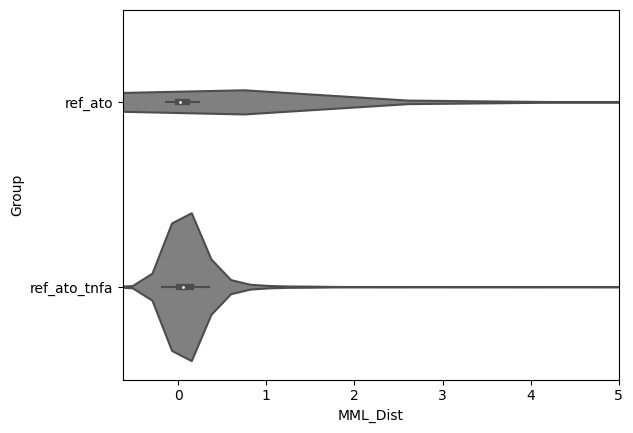

In [146]:
sb.violinplot( data=temp, x='MML_Dist',y='Group', color='grey')
plt.xlim([np.min(temp.MML_Dist),5])
plt.savefig('../../../OrgAlign/[Github]OrgAlign/[IN_PROGRESS]G2G_validation_tests/ms_data_figs/MML_Dist_allTFs.png')

In [147]:
arr = []
arr_diff = []
for i in range(len(ref_ato_mmldists )):
    arr.append(ref_ato_mmldists[i] > ref_ato_tnf_mmldists[i] )
    arr_diff.append(((ref_ato_mmldists[i] - ref_ato_tnf_mmldists[i])) ) 
print(np.unique(arr, return_counts=True)) 
genes = np.asarray(genes)
len(genes[arr]) 

(array([False,  True]), array([827, 544]))


544

In [148]:
print(adata_ref_t1.shape)
print(adata_query_spt.shape)
print(adata_Tcells_TNF.shape)

(1413, 20240)
(6558, 20240)
(119, 33538)


In [149]:
#avail_genes = pd.read_csv('tnfa_pathway_genes_list.csv')
#avail_genes = np.intersect1d( avail_genes['0'], adata_Tcells_TNF.var_names)
avail_genes = np.intersect1d(np.intersect1d(adata_ref_t1.var_names, adata_query_spt.var_names), adata_Tcells_TNF.var_names )

# Let's pick the pathways of interest from the above list and check their alignment statistics
from gsea_api.molecular_signatures_db import MolecularSignaturesDatabase
from adjustText import adjust_text
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import zscore

class InterestingGeneSets:
    
    def __init__(self):        
        self.SETS = {}
        self.dbs = {}
        self.msigdb = MolecularSignaturesDatabase('../../../OrgAlign/msigdb', version='7.5.1')
        self.dbs['kegg'] = self.msigdb.load('c2.cp.kegg', 'symbols')
        self.dbs['hallmark'] = self.msigdb.load('h.all', 'symbols')
        self.dbs['gobp'] = self.msigdb.load('c5.go.bp', 'symbols')
        self.dbs['gocc'] = self.msigdb.load('c5.go.cc', 'symbols')
        self.dbs['reac'] = self.msigdb.load('c2.cp.reactome', 'symbols')
        
    def add_new_set_from_msigdb(self, db_name, dbsetname, avail_genes, usersetname):
        self.SETS[usersetname] = np.intersect1d(list(self.dbs[db_name].gene_sets_by_name[dbsetname].genes), avail_genes)

    def add_new_set(self, geneset, usersetname, avail_genes):
        geneset = np.asarray(geneset)
        self.SETS[usersetname] = geneset[np.where([g in avail_genes for g in geneset])]

IGS = InterestingGeneSets()
IGS.add_new_set_from_msigdb('hallmark', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB',avail_genes, 'TNF_alpha_signaling_via_NFKB')
IGS.SETS['TNF_alpha_signaling_via_NFKB_TFsOnly'] = np.intersect1d(human_TFs, IGS.SETS['TNF_alpha_signaling_via_NFKB'] )
len(avail_genes) 

20240

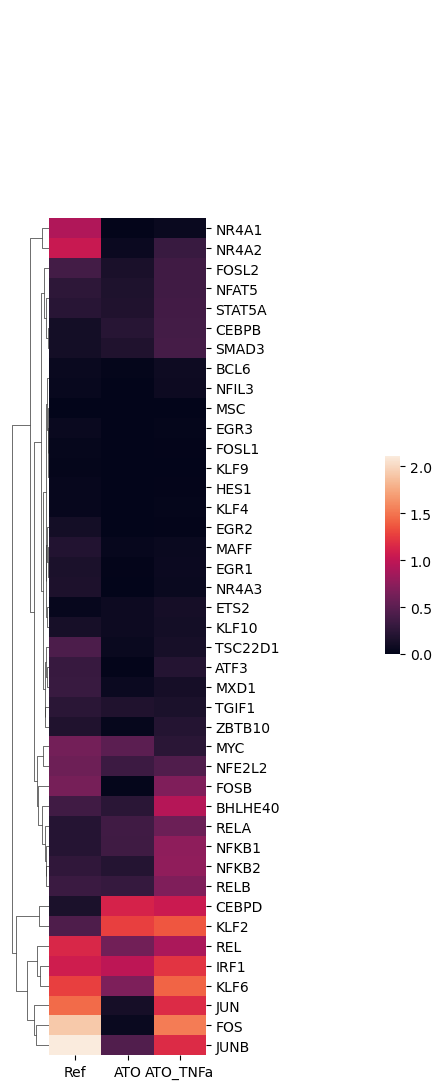

In [151]:
df = pd.DataFrame(mean_expression_df) 
df.columns = ['Ref','ATO','ATO_TNFa']
df.index = genes
df = df.loc[IGS.SETS['TNF_alpha_signaling_via_NFKB_TFsOnly']]
sb.clustermap(df, col_cluster=False, figsize=(3,11), cbar_pos=(1.3, 0.4, 0.05, 0.18))
plt.savefig('../../../OrgAlign/[Github]OrgAlign/[IN_PROGRESS]G2G_validation_tests/ms_data_figs/validation_related_heatmap_tnf_pathway_TFs.png', bbox_inches='tight')

In [87]:
mean_expression_df = []
ref_ato_mmldists = []
ref_ato_tnf_mmldists = []
genes = []
#mean_expression_df_zscore = []

TFs_wo_tnf = np.setdiff1d( human_TFs,  IGS.SETS['TNF_alpha_signaling_via_NFKB'])
for g in tqdm(TFs_wo_tnf ):
    genes.append(g)
    x, ref_ato_mmldist, ref_ato_tnf_mmldist  = check_dists(g)
    mean_expression_df.append(x)
    ref_ato_mmldists.append(ref_ato_mmldist)
    ref_ato_tnf_mmldists.append(ref_ato_tnf_mmldist)
    #mean_expression_df_zscore.append(x_zscore)

100%|██████████| 1329/1329 [02:42<00:00,  8.15it/s]


In [88]:
ref_ato_mmldists = np.asarray(ref_ato_mmldists)
ref_ato_tnf_mmldists = np.asarray(ref_ato_tnf_mmldists)
print(np.mean(ref_ato_mmldists))
print(np.mean(ref_ato_tnf_mmldists))

0.19080127915726108
0.14875161775771256


In [89]:
import scipy.stats as stats
stats.wilcoxon(ref_ato_mmldists, ref_ato_tnf_mmldists)

WilcoxonResult(statistic=333710.0, pvalue=1.0669622687172054e-14)

In [28]:
data = list(ref_ato_mmldists) + list(ref_ato_tnf_mmldists) 
labels = list(np.repeat('ref_ato',len(ref_ato_mmldists))) + list(np.repeat('ref_ato_tnfa',len(ref_ato_tnf_mmldists)))

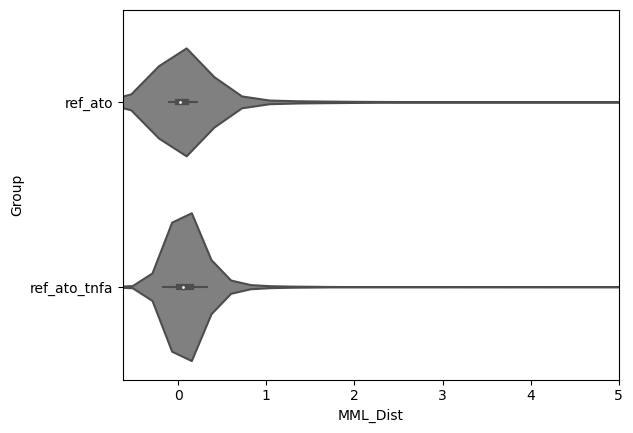

In [90]:
data = list(ref_ato_mmldists) + list(ref_ato_tnf_mmldists) 
labels = list(np.repeat('ref_ato',len(ref_ato_mmldists))) + list(np.repeat('ref_ato_tnfa',len(ref_ato_tnf_mmldists)))
temp = pd.DataFrame([data, labels]).transpose()
temp.columns=['MML_Dist', 'Group']
temp
temp['MML_Dist'] = temp['MML_Dist'].astype('float')
sb.violinplot( data=temp, x='MML_Dist',y='Group', color='grey')
plt.xlim([np.min(temp.MML_Dist),5])
plt.savefig('../../../OrgAlign/[Github]OrgAlign/[IN_PROGRESS]G2G_validation_tests/ms_data_figs/MML_Dist_excludingTNF_TFs.png')

### TNFa pathway genes 

In [152]:
from tqdm import tqdm
mean_expression_df = []
ref_ato_mmldists = []
ref_ato_tnf_mmldists = []
genes = []
#mean_expression_df_zscore = []
for g in tqdm(IGS.SETS['TNF_alpha_signaling_via_NFKB']):
    if(g=='MSC'):
        continue
    genes.append(g)
    x, ref_ato_mmldist, ref_ato_tnf_mmldist  = check_dists(g)
    mean_expression_df.append(x)
    ref_ato_mmldists.append(ref_ato_mmldist)
    ref_ato_tnf_mmldists.append(ref_ato_tnf_mmldist)
    #mean_expression_df_zscore.append(x_zscore)
    
# 195 TNFa genes are evaluated 

100%|██████████| 196/196 [00:27<00:00,  7.13it/s]


In [153]:
arr = []
arr_diff = []
for i in range(len(ref_ato_mmldists )):
    arr.append(ref_ato_mmldists[i] > ref_ato_tnf_mmldists[i] )
    arr_diff.append(((ref_ato_mmldists[i] - ref_ato_tnf_mmldists[i])) )

In [154]:
np.unique(arr, return_counts=True)

(array([False,  True]), array([109,  86]))

In [155]:
print(np.mean(ref_ato_mmldists)) 
print(np.mean(ref_ato_tnf_mmldists))

2.20228
1.3834241025641025


<Axes: xlabel='MML_Dist', ylabel='Group'>

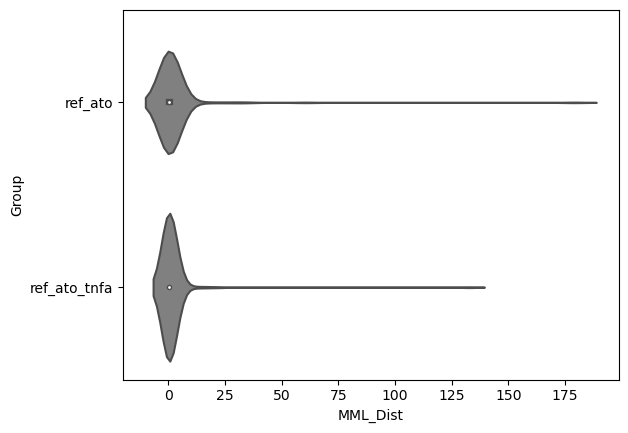

In [156]:
data = list(ref_ato_mmldists) + list(ref_ato_tnf_mmldists) 
labels = list(np.repeat('ref_ato',len(ref_ato_mmldists))) + list(np.repeat('ref_ato_tnfa',len(ref_ato_tnf_mmldists)))
temp = pd.DataFrame([data, labels]).transpose()
temp.columns=['MML_Dist', 'Group']
temp
temp['MML_Dist'] = temp['MML_Dist'].astype('float')
sb.violinplot( data=temp, x='MML_Dist',y='Group', color='grey')
#plt.xlim([np.min(temp.MML_Dist),100])

In [157]:
import scipy.stats as stats
stats.wilcoxon(ref_ato_mmldists, ref_ato_tnf_mmldists)

WilcoxonResult(statistic=8588.5, pvalue=0.22064123257671797)

In [161]:
len(df)

195

195


/home/jovyan/my-conda-envs/genes2genes-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


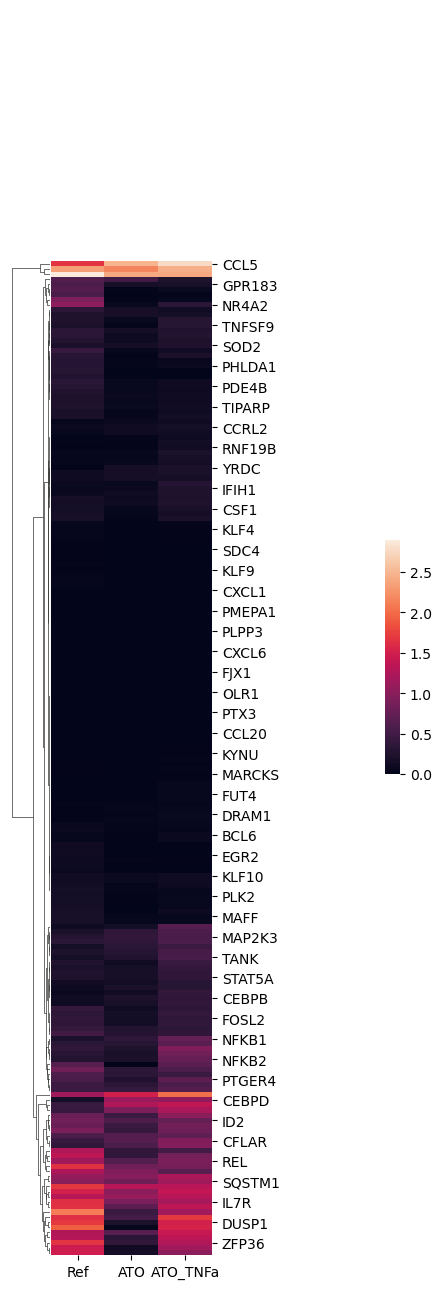

In [160]:
df = pd.DataFrame(mean_expression_df) 
df.columns = ['Ref','ATO','ATO_TNFa']
df.index = genes
print(len(genes))
sb.clustermap(df, col_cluster=False, figsize=(3,13), vmax=np.max(np.max(df)) , cbar_pos=(1.3, 0.4, 0.05, 0.18))

plt.savefig('../../../OrgAlign/[Github]OrgAlign/[IN_PROGRESS]G2G_validation_tests/ms_data_figs/validation_related_heatmap_tnf_pathway_genes_full.png', bbox_inches='tight')